In [5]:
import pandas as pd
import numpy as np
import re
df = pd.read_csv('jobs_dataset_cleaned.csv')
print(df.columns.tolist())

['company', 'rating', 'location', 'positionName', 'description', 'salary', 'url', 'jobType/0', 'jobType/1', 'jobType/2', 'jobType/3', 'searchInput/country', 'searchInput/position', 'externalApplyLink', 'salary_num', 'state', 'is_remote', 'is_senior', '/0', '/1', '/2', '/3', 'is_CA_NY', 'high_salary']


In [4]:
# 1. Basic Cleaning
df = df.drop_duplicates()
df = df.rename(columns=lambda x: x.strip())
df['rating'] = df['rating'].fillna(0)

In [6]:
# 2. Clean Salary Field
def clean_salary(s):
    if pd.isna(s):
        return np.nan
    s = str(s).replace('$', '').replace(',', '').lower()
    if 'hour' in s:
        try:
            hourly = float(re.findall(r'\d+\.?\d*', s)[0])
            return hourly * 40 * 52
        except:
            return np.nan
    numbers = re.findall(r'\d+\.?\d*', s)
    if len(numbers) == 2:
        return (float(numbers[0]) + float(numbers[1])) / 2
    elif len(numbers) == 1:
        return float(numbers[0])
    else:
        return np.nan

df['salary_num'] = df['salary'].apply(clean_salary)


In [8]:
# 3. Keep only U.S. states
df['state'] = df['location'].apply(lambda x: str(x).split(',')[-1].strip() if pd.notna(x) else None)

us_states = ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME',
             'MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA',
             'RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']

df = df[df['state'].isin(us_states)]

In [9]:
# 4. Fix Job Type Columns
jobtype_cols = [c for c in df.columns if 'jobtype' in c.lower()]

def detect_job_type(row):
    text = ' '.join([str(row[c]) for c in jobtype_cols if pd.notna(row[c])]).lower()
    if 'full' in text:
        return 'Full-time'
    elif 'part' in text:
        return 'Part-time'
    elif 'contract' in text:
        return 'Contract'
    elif 'intern' in text:
        return 'Internship'
    elif 'temp' in text:
        return 'Temporary'
    else:
        return 'Unknown'

df['job_type'] = df.apply(detect_job_type, axis=1)

In [11]:
# 5. Add Feature Columns
df['is_senior'] = df['positionName'].apply(lambda x: 1 if isinstance(x, str) and any(w in x.lower() for w in ['senior', 'lead', 'manager']) else 0)
df['is_remote'] = df['location'].apply(lambda x: 1 if isinstance(x, str) and 'remote' in x.lower() else 0)
df['is_CA_NY'] = df['state'].apply(lambda s: 1 if s in ['CA', 'NY'] else 0)

In [12]:
# 6. Final Columns Selection
final_cols = ['company', 'positionName', 'rating', 'location', 'state',
              'salary', 'salary_num', 'job_type', 'is_senior', 'is_remote', 'is_CA_NY']
df_final = df[final_cols]

In [13]:
# 7. Save the Cleaned Dataset
df_final.to_csv('jobs_dataset_final.csv', index=False)
print("✅ Clean dataset saved as 'jobs_dataset_final.csv' with shape:", df_final.shape)

✅ Clean dataset saved as 'jobs_dataset_final.csv' with shape: (240, 11)


In [14]:
# 8. Machine Learning Model Implementation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
# Prepare Data
df_ml = df_final.copy()

In [16]:
# Remove rows with missing salary
df_ml = df_ml.dropna(subset=['salary_num'])

In [17]:
# Define target (High Salary = 1 if salary > median)
median_salary = df_ml['salary_num'].median()
df_ml['high_salary'] = (df_ml['salary_num'] > median_salary).astype(int)

In [18]:
# Select features
X = df_ml[['rating', 'is_senior', 'is_remote', 'is_CA_NY']]
y = df_ml['high_salary']

In [19]:
# One-hot encode job type
X = pd.concat([X, pd.get_dummies(df_ml['job_type'], prefix='type', drop_first=True)], axis=1)

In [20]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Scale numeric features
scaler = StandardScaler()
X_train[['rating']] = scaler.fit_transform(X_train[['rating']])
X_test[['rating']] = scaler.transform(X_test[['rating']])

In [22]:
# 9. Logistic Regression Model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
print("=== Logistic Regression ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_log)*100, 2), "%")
print(classification_report(y_test, y_pred_log))

=== Logistic Regression ===
Accuracy: 64.58 %
              precision    recall  f1-score   support

           0       0.55      0.58      0.56        19
           1       0.71      0.69      0.70        29

    accuracy                           0.65        48
   macro avg       0.63      0.63      0.63        48
weighted avg       0.65      0.65      0.65        48



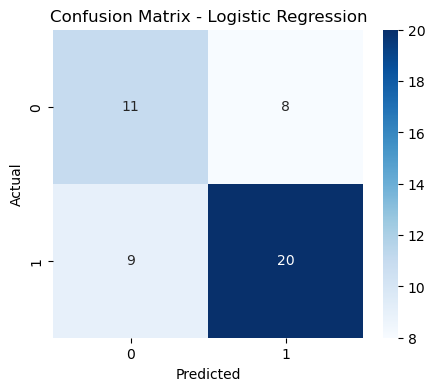

In [23]:
# Confusion Matrix - Logistic
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [24]:
# 10. Random Forest Model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("\n=== Random Forest ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf)*100, 2), "%")
print(classification_report(y_test, y_pred_rf))


=== Random Forest ===
Accuracy: 56.25 %
              precision    recall  f1-score   support

           0       0.46      0.63      0.53        19
           1       0.68      0.52      0.59        29

    accuracy                           0.56        48
   macro avg       0.57      0.57      0.56        48
weighted avg       0.59      0.56      0.57        48



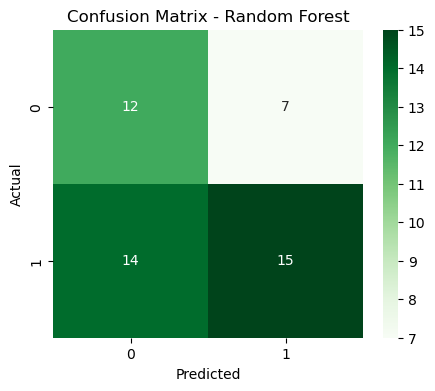

In [25]:
# Confusion Matrix - Random Forest
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

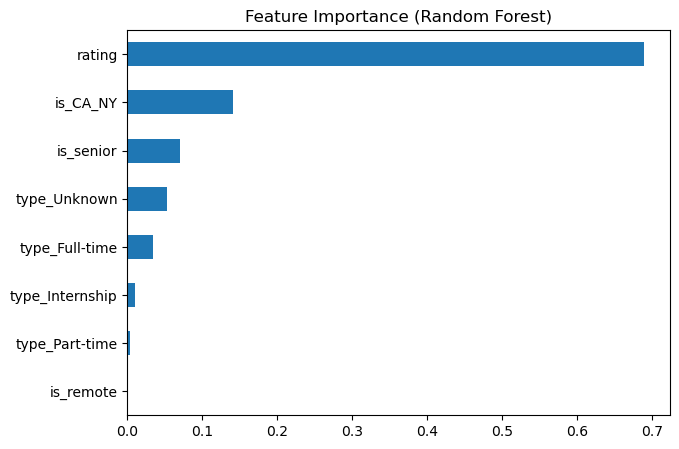

In [26]:
# 11. Feature Importance
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(7,5))
plt.title("Feature Importance (Random Forest)")
plt.show()

In [27]:
# 12. Summary
log_acc = accuracy_score(y_test, y_pred_log)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"\nComparison:\nLogistic Regression Accuracy = {log_acc:.2f}\nRandom Forest Accuracy = {rf_acc:.2f}")


Comparison:
Logistic Regression Accuracy = 0.65
Random Forest Accuracy = 0.56
